In [1]:
!pip install transformers

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
#@title import packages

import torch
import numpy as np
import pandas as pd
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans

import torch.nn as nn

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Normalize, Resize, Compose, ToPILImage

In [4]:
import pandas as pd

# read the part labels
part_labels = {}
with open('../data/CUB_200_2011/parts/parts.txt', 'r') as f:
    for line in f:
        part_id, part_name = line.strip().split(' ', 1)  # Split on the first space only
        part_labels[int(part_id)] = part_name
print(part_labels)
# read coordinates of the part locations
part_locations = pd.read_csv('../data/CUB_200_2011/parts/part_locs.txt', sep=' ', header=None, 
                             names=['image_id', 'part_id', 'x', 'y', 'visible', 'feature'])
print(part_locations.head())

{1: 'back', 2: 'beak', 3: 'belly', 4: 'breast', 5: 'crown', 6: 'forehead', 7: 'left eye', 8: 'left leg', 9: 'left wing', 10: 'nape', 11: 'right eye', 12: 'right leg', 13: 'right wing', 14: 'tail', 15: 'throat'}
   image_id  part_id      x      y  visible  feature
0         1        1    0.0    0.0        0      NaN
1         1        2  312.0  182.0        1      NaN
2         1        3    0.0    0.0        0      NaN
3         1        4    0.0    0.0        0      NaN
4         1        5  186.0   45.0        1      NaN


In [5]:
#@title Plotting functions

import argparse
import torch
import matplotlib.pyplot as plt
import torchvision.transforms
from torch import nn
from torchvision import transforms
import torch.nn.modules.utils as nn_utils
import math
#import timm
import types
from pathlib import Path
from typing import Union, List, Tuple
from PIL import Image
from matplotlib.colors import ListedColormap

def imsc(img, *args, quiet=False, lim=None, interpolation='lanczos', **kwargs):
    r"""Rescale and displays an image represented as a img.
    The function scales the img :attr:`im` to the [0 ,1] range.
    The img is assumed to have shape :math:`3\times H\times W` (RGB)
    :math:`1\times H\times W` (grayscale).
    Args:
        img (:class:`torch.Tensor` or :class:`PIL.Image`): image.
        quiet (bool, optional): if False, do not display image.
            Default: ``False``.
        lim (list, optional): maximum and minimum intensity value for
            rescaling. Default: ``None``.
        interpolation (str, optional): The interpolation mode to use with
            :func:`matplotlib.pyplot.imshow` (e.g. ``'lanczos'`` or
            ``'nearest'``). Default: ``'lanczos'``.
    Returns:
        :class:`torch.Tensor`: Rescaled image img.
    """
    if isinstance(img, Image.Image):
        img = pil_to_tensor(img)
    handle = None
    with torch.no_grad():
        if not lim:
            lim = [img.min(), img.max()]
        img = img - lim[0]  # also makes a copy
        img.mul_(1 / (lim[1] - lim[0]))
        img = torch.clamp(img, min=0, max=1)
        if not quiet:
            bitmap = img.expand(3,
                                *img.shape[1:]).permute(1, 2, 0).cpu().numpy()
    return bitmap

def draw_correspondences(points1: List[Tuple[float, float]], points2: List[Tuple[float, float]],
                         image1: Image.Image, image2: Image.Image) -> Tuple[plt.Figure, plt.Figure]:
    """
    draw point correspondences on images.
    :param points1: a list of (y, x) coordinates of image1, corresponding to points2.
    :param points2: a list of (y, x) coordinates of image2, corresponding to points1.
    :param image1: a PIL image.
    :param image2: a PIL image.
    :return: two figures of images with marked points.
    """
    assert len(points1) == len(points2), f"points lengths are incompatible: {len(points1)} != {len(points2)}."
    num_points = len(points1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    ax1.axis('off')
    ax2.axis('off')
    #ax1.imshow(image1)
    #ax2.imshow(image2)
    ax1.imshow(imsc(image1))
    ax2.imshow(imsc(image2))

    if not points1:
      return fig

    if num_points > 15:
        cmap = plt.get_cmap('tab10')
    else:
        cmap = ListedColormap(["red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
                               "maroon", "black", "white", "chocolate", "gray", "blueviolet"])
    colors = np.array([cmap(x) for x in range(num_points)])
    radius1, radius2 = 8, 1
    for point1, point2, color in zip(points1, points2, colors):
        y1, x1 = point1
        circ1_1 = plt.Circle((x1, y1), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ1_2 = plt.Circle((x1, y1), radius2, facecolor=color, edgecolor='white')
        ax1.add_patch(circ1_1)
        ax1.add_patch(circ1_2)
        y2, x2 = point2
        circ2_1 = plt.Circle((x2, y2), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ2_2 = plt.Circle((x2, y2), radius2, facecolor=color, edgecolor='white')
        ax2.add_patch(circ2_1)
        ax2.add_patch(circ2_2)
    return fig

def draw_all_correspondences(all_points_1, all_points_2, query, prototypes) -> Tuple[plt.Figure, plt.Figure]:

    n_cols = len(prototypes)
    base_size = 5
    plot_ratio = n_cols / 2.0
    fig, ax = plt.subplots(2, n_cols, figsize=(plot_ratio*base_size, base_size))

    for counter, (prototype_img, points_1, points_2) in enumerate(zip(prototypes, all_points_1, all_points_2)):

      num_points = len(points_1)

      ax[0, counter].axis('off')
      ax[0, counter].imshow(imsc(query[0]))

      ax[1, counter].axis('off')
      ax[1, counter].imshow(imsc(prototype_img))

      if not points_1: continue

      if num_points > 15:
        cmap = plt.get_cmap('tab10')
      else:
        cmap = ListedColormap(["red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
                               "maroon", "black", "white", "chocolate", "gray", "blueviolet"])

      colors = np.array([cmap(x) for x in range(num_points)])
      radius_1, radius_2 = 8, 1

      for point_1, point_2, color in zip(points_1, points_2, colors):

          y_1, x_1 = point_1
          circ_1_1 = plt.Circle((x_1, y_1), radius_1, facecolor=color, edgecolor='white', alpha=0.5)
          circ_1_2 = plt.Circle((x_1, y_1), radius_2, facecolor=color, edgecolor='white')
          ax[0, counter].add_patch(circ_1_1)
          ax[0, counter].add_patch(circ_1_2)

          y_2, x_2 = point_2
          circ_2_1 = plt.Circle((x_2, y_2), radius_1, facecolor=color, edgecolor='white', alpha=0.5)
          circ_2_2 = plt.Circle((x_2, y_2), radius_2, facecolor=color, edgecolor='white')
          ax[1, counter].add_patch(circ_2_1)
          ax[1, counter].add_patch(circ_2_2)

    plt.tight_layout()
    
    
    return fig
    

In [6]:
#@title create dataset


from transformers import AutoProcessor

# get the clip model
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")

# create a dataset class
class CUB(Dataset):
    def __init__(self, base_path, train=True):

        self.base_path = base_path

        self.labels = pd.read_csv(''.join([base_path, 'image_class_labels.txt']), header=None, sep=" ", names=["id", "label"])
        self.train_test_split = pd.read_csv(''.join([base_path, 'train_test_split.txt']), header=None, sep=" ", names=["id", "is_train"])
        self.filenames = pd.read_csv(''.join([base_path, 'images.txt']), header=None, sep=" ")

        # add the labels of part
        self.part_labels = part_labels
        self.part_locations = part_locations
        
        if train:
          mask = self.train_test_split.is_train.values == 1
        else:
          mask = self.train_test_split.is_train.values == 0

        self.filenames = self.filenames.iloc[mask]
        self.labels = self.labels[mask]

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, index):

        y = self.labels.iloc[index, 1] - 1
        file_name = self.filenames.iloc[index, 1]

        x = Image.open(''.join([self.base_path, 'images/', file_name])).convert('RGB')
        x = processor(images=x, return_tensors="pt")

        return x['pixel_values'].squeeze(), y



c:\Users\chens\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


labels number of the samples : [np.int64(110), np.int64(120), np.int64(13), np.int64(74), np.int64(145), np.int64(138), np.int64(116), np.int64(87), np.int64(135), np.int64(102)]
class label of the samples : ['111.Loggerhead_Shrike' '121.Grasshopper_Sparrow' '014.Indigo_Bunting'
 '075.Green_Jay' '146.Forsters_Tern' '139.Scarlet_Tanager'
 '117.Clay_colored_Sparrow' '088.Western_Meadowlark' '136.Barn_Swallow'
 '103.Sayornis']


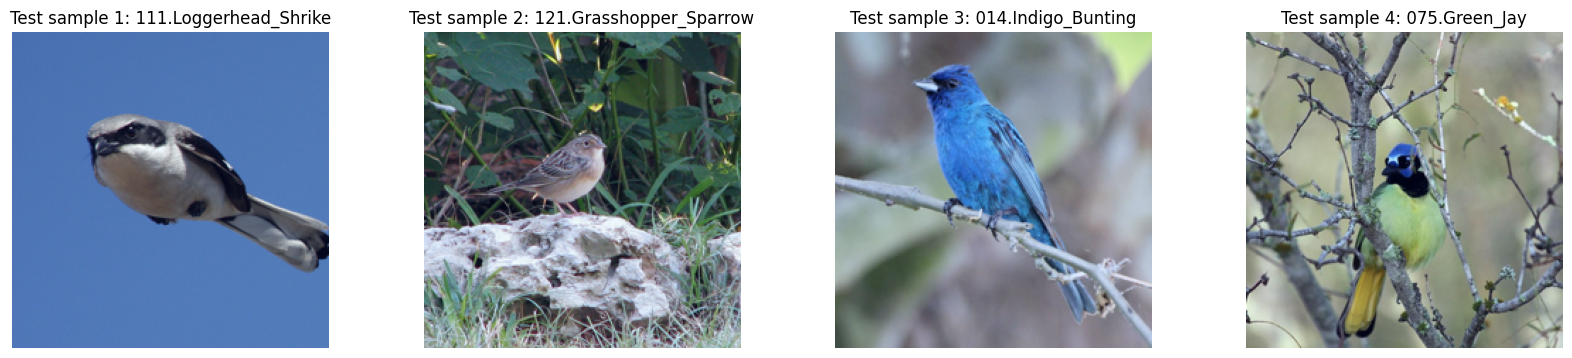

In [7]:
#@title dataset and dataloader and load samples

import random

# base_path = 'drive/MyDrive/CoSegXAI/datasets/cub200/CUB_200_2011/CUB_200_2011/'
base_path = '../data/CUB_200_2011/' # You need to change this.

test_dataset = CUB(base_path, train=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=0)

random.seed(0)
inputs, labels = [], []
# get 10 random samples from the test dataset
data_indices = random.sample(range(test_dataset.__len__()), 10)

for counter, data_idx in enumerate(data_indices):

  x, y = test_dataset.__getitem__(data_idx)

  inputs.append(x)
  labels.append(y)

# This is class label of the samples
print('labels number of the samples :', labels)
# get the name of the classes
class_names = pd.read_csv(''.join([base_path, 'classes.txt']), header=None, sep=" ", names=["id", "name"])
class_names = class_names.iloc[labels].name.values
print('class label of the samples :', class_names)



# plt.figure(1)
# plt.subplot(141)
# plt.imshow(imsc(inputs[0]))
# # plt.title('Test sample 1')
# # show the sample class name
# plt.title(f"Test sample 1: {class_names[0]}")
# plt.axis('off')
# plt.subplot(142)
# plt.imshow(imsc(inputs[1]))
# plt.title(f"Test sample 2: {class_names[1]}")
# plt.axis('off')
# plt.subplot(143)
# plt.imshow(imsc(inputs[2]))
# plt.title(f"Test sample 3: {class_names[2]}")
# plt.axis('off')
# plt.subplot(144)
# plt.imshow(imsc(inputs[3]))
# plt.title('Test sample 4')
# plt.axis('off')
# plt.show()

# change a new way to show the samples for easy to read
plt.figure(figsize=(20, 12))

samples = [inputs[0], inputs[1], inputs[2], inputs[3]]
titles = [f"Test sample 1: {class_names[0]}", f"Test sample 2: {class_names[1]}",
          f"Test sample 3: {class_names[2]}", f"Test sample 4: {class_names[3]}"]

for i, (sample, title) in enumerate(zip(samples, titles)):
    plt.subplot(1, 4, i+1)
    plt.imshow(imsc(sample))
    plt.title(title)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3,hspace=0.2)
plt.show()


In [8]:
#@title feature extractor

from PIL import Image
import requests
from transformers import CLIPVisionModel

# Load the CLIP model
model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch16")


In [9]:
#@title dataset for loading prototypes
# Loads images from the specified path.
# Applies transformations to prepare the images for model input.
# Returns each image and its corresponding label when iterated.
class Prototype_Dataset(Dataset):
    def __init__(self, base_path, file_names, labels):

        self.base_path = base_path
        self.img_size = 224

        self.labels = labels
        self.file_names = file_names

        self.transforms = Compose([
                ToTensor(),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):

        y = self.labels[index]
        file_name = self.file_names[index]

        x = Image.open(''.join([self.base_path, 'images/', file_name])).convert('RGB')
        x = processor(images=x, return_tensors="pt")

        return x['pixel_values'].squeeze(), y


In [10]:
#@title keypoint counting classifier

from dataclasses import dataclass, field
from torch.nn.functional import cosine_similarity
from typing import List, Tuple
from sklearn.decomposition import PCA

@dataclass
class Keypoint_Counting_Classifier:
    encoder: nn.Module
    prototype_tokens: torch.Tensor
    prototype_file_names: List[str] = field(default_factory=list)
    prototype_labels: List[int] = field(default_factory=list)
    number_of_prototypes: int = 10
    number_of_pairs: int = 10
    number_of_classes = 200
    image_size: int = 224
    patch_size: int = 14
    stride: int = 14
    # base_path: str = 'drive/MyDrive/CoSegXAI/datasets/cub200/CUB_200_2011/CUB_200_2011/'
    base_path : str = '../data/CUB_200_2011/' 
    device: str = 'cuda'

    def __post_init__(self):

        self.encoder.eval()
        self.encoder = self.encoder.to(self.device)

        self.number_of_patches, self.token_dimensionality = self.get_number_of_patches_and_dim()
        self.part_labels = part_labels
        self.part_locations = part_locations
        
    def predict_and_plot(self, query) -> np.ndarray:

        query = query.to(self.device)
        # retrieve the closest prototypes using cosine similarity
        top_k_similar_prototypes = self.get_k_closest_prototypes(query)

        # extract patches from the query and the prototypes
        query_patches = self.get_patches(query).reshape(-1, self.token_dimensionality)
        prototype_patches, prototype_images, prototype_labels = self.get_prototype_patches(top_k_similar_prototypes)
        prototype_patches = prototype_patches.reshape(-1, self.token_dimensionality)

        # find the best buddies between the query and the prototypes(match the patches)
        best_buddies, nn_query = self.get_best_buddies(query, query_patches, prototype_patches)

        query_patches
        # cluster the best buddies for classification
        cluster_labels, indices_to_show = self.cluster_best_buddies(best_buddies, query_patches, prototype_patches, nn_query)
        query_indices_to_show, prototype_indices_to_show = self.find_query_and_prototype_indices(best_buddies, indices_to_show, nn_query)
        print("Query indices to show: ", query_indices_to_show)
        print("Prototype indices to show: ", prototype_indices_to_show)
        paired_indices_to_show = self.find_pairs_of_query_and_prototype_indices(query_indices_to_show, prototype_indices_to_show)
        print("Paired indices to show: ", paired_indices_to_show)
        
        inidices_to_plot_1, inidices_to_plot_2 = self.convert_to_plot_indices(paired_indices_to_show)
        print("indices plot 1 : ", inidices_to_plot_1)
        print("indices plot 2 : ", inidices_to_plot_2)
        
        # generate the predictions and plot the correspondences
        predictions = self.get_prediction(inidices_to_plot_1, inidices_to_plot_2, prototype_labels)
        
        fig = draw_all_correspondences(inidices_to_plot_1, inidices_to_plot_2, query, prototype_images)

        return predictions


    # compute cosine similarity between the query and the prototypes tokens to retrieve the closest prototypes
    def get_k_closest_prototypes(self, query) -> torch.Tensor:

        query_token = self.encoder(query).pooler_output
        similarity = cosine_similarity(query_token, self.prototype_tokens)
        top_k_similar_prototypes_indices = torch.topk(similarity, self.number_of_prototypes)[1]

        return [i.item() for i in top_k_similar_prototypes_indices]

    # Load the prototype images and retrieve patches
    def get_prototype_patches(self, top_k_indices) -> torch.Tensor:

        top_k_prototypes = [self.prototype_file_names[i] for i in top_k_indices]
        top_k_labels = [self.prototype_labels[i] for i in top_k_indices]

        prototype_dataset = Prototype_Dataset(self.base_path, top_k_prototypes, top_k_labels)
        prototype_loader = DataLoader(prototype_dataset, batch_size=len(top_k_labels), shuffle=False, num_workers=0)
        prototypes, labels = next(iter(prototype_loader))

        patches = self.get_patches(prototypes.to(self.device))

        return patches, prototypes,labels

    # Extracts patch embeddings from an image by using the encoder's last hidden state. ? 
    # last hihhden state : (batch_size, sequence_length, hidden_size)
    def get_patches(self, query) -> torch.Tensor:
        return self.encoder(query).last_hidden_state[:, 1:, :].numpy(force=True)

    # identify the best buddy patches, which are mutually closest patches between the query and the prototypes
    def get_best_buddies(self, query, query_patches, prototype_patches) -> Tuple[list, np.ndarray, list]:

        nn_query, _ = pairwise_distances_argmin_min(query_patches, prototype_patches, axis=1, metric='cosine')
        nn_prototypes, _ = pairwise_distances_argmin_min(query_patches, prototype_patches, axis=0, metric='cosine')

        best_buddies = nn_prototypes[nn_query] == np.arange(self.number_of_patches)

        foreground_masks = self.get_foreground_masks(np.concatenate((query_patches, prototype_patches)))
        #foreground_masks = self.update_foreground_masks(query, foreground_masks) # This is a prototype I am working on to fix the foreground masking. But still not working perfectly.

        n_cols = 10
        base_size = 5
        plot_ratio = n_cols / 2.0
        sqrt_of_patch = int(np.sqrt(self.number_of_patches))

        fig, ax = plt.subplots(2, n_cols, figsize=(plot_ratio*base_size, base_size))

        for counter, foreground_mask_i in enumerate(foreground_masks[1:]):

            ax[0, counter].axis('off')
            ax[0, counter].imshow(foreground_masks[0].reshape(sqrt_of_patch, sqrt_of_patch))

            ax[1, counter].axis('off')
            ax[1, counter].imshow(foreground_mask_i.reshape(sqrt_of_patch, sqrt_of_patch))

        plt.show()

        query_foreground_mask = foreground_masks[0]
        prototype_foreground_mask = foreground_masks[1:].flatten()

        prototypes_foreground_new_coordinates = nn_prototypes[prototype_foreground_mask]
        prototypes_foreground_mask_new_coordinates = np.zeros(self.number_of_patches, dtype=bool)
        prototypes_foreground_mask_new_coordinates[prototypes_foreground_new_coordinates] = True

        best_buddies = np.bitwise_and(best_buddies, query_foreground_mask)
        best_buddies = np.bitwise_and(best_buddies, prototypes_foreground_mask_new_coordinates)

        if np.sum(best_buddies) < 15:
            best_buddies = nn_prototypes[nn_query] == np.arange(self.number_of_patches)

        return best_buddies, nn_query

    # use PCA to generate foreground masks by the thresholding based on the principal components
    def get_foreground_masks(self, token_patches) -> np.ndarray:

        pca = PCA(n_components=10)
        pca_component_to_threshold = 1 # For CLIP, this seems to be quite stable for some reason.
        pca_features = pca.fit_transform(token_patches.reshape(-1, self.token_dimensionality))

        threshold_coefficient = 0.0
        threshold_base = np.mean(pca_features[:, pca_component_to_threshold])
        threshold_factor = threshold_coefficient * np.std(pca_features[:, pca_component_to_threshold])
        threshold = threshold_base + threshold_factor

        foreground_mask = pca_features[:, pca_component_to_threshold] > threshold

        plt.figure(1)
        plt.hist(pca_features[:, pca_component_to_threshold])
        plt.vlines(threshold, 0, 2000)
        plt.show()

        return np.array(foreground_mask).reshape(-1, self.number_of_patches)
    
    # refines the foreground masks by masking the image and recalculating the patch embeddings
    def update_foreground_masks(self, query, foreground_masks):

        query = query.to(self.device)
        top_k_similar_prototypes = self.get_k_closest_prototypes(query)
        prototype_patches, prototype_images, prototype_labels = self.get_prototype_patches(top_k_similar_prototypes)

        query_and_prototype_images = torch.cat((query, prototype_images.to(self.device)))

        foreground_masks_big = torch.tensor(foreground_masks.reshape(-1, 1, 14, 14), device=self.device)
        foreground_masks_big = torchvision.transforms.functional.resize(foreground_masks_big, size=224)

        query_and_prototype_images_0 = query_and_prototype_images * foreground_masks_big
        query_and_prototype_images_1 = query_and_prototype_images * ~foreground_masks_big

        unmasked_tokens = self.encoder(query_and_prototype_images).last_hidden_state[:, 1:, :]
        masked_tokens_0 = self.encoder(query_and_prototype_images_0).last_hidden_state[:, 1:, :]
        masked_tokens_1 = self.encoder(query_and_prototype_images_1).last_hidden_state[:, 1:, :]

        sim_0 = torch.mean(torch.nn.functional.cosine_similarity(unmasked_tokens, masked_tokens_0))
        sim_1 = torch.mean(torch.nn.functional.cosine_similarity(unmasked_tokens, masked_tokens_1))

        if sim_0 >= sim_1: return foreground_masks
        else: return ~foreground_masks

    # clustering the best buddy patches using K-means clustering for final classification
    def cluster_best_buddies(self, best_buddies, query_patches, prototype_patches, nn_query) -> Tuple[np.ndarray, np.ndarray]:

        bb_query = query_patches[best_buddies, :]
        bb_prototypes = prototype_patches[nn_query[best_buddies], :]

        bb_combined_patches = np.concatenate((bb_query, bb_prototypes), axis=1)
        bb_combined_patches = bb_combined_patches / np.linalg.norm(bb_combined_patches, axis=1, keepdims=True)

        kmeans = KMeans(n_clusters=self.number_of_pairs, random_state=0, n_init=10).fit(bb_combined_patches)
        indices_to_show = np.argmin(kmeans.transform(bb_combined_patches), axis=0)

        return kmeans.labels_, indices_to_show

    # find the indices of patches in the query and the prototypes
    def find_query_and_prototype_indices(self, best_buddies, indices_to_show, nn_query) -> Tuple[np.ndarray, np.ndarray]:

        indices_to_show = np.nonzero(best_buddies)[0][indices_to_show]
        query_indices_to_show = np.arange(self.number_of_patches)[indices_to_show]
        prototype_indices_to_show = nn_query[indices_to_show]

        return query_indices_to_show, prototype_indices_to_show

    # Matches query and prototype patch indices to find pairs for plotting.
    def find_pairs_of_query_and_prototype_indices(self, query_indices_to_show, prototype_indices_to_show):

        indices_query_prototype_pairs_to_show = []
        number_of_patches_prototypes = [np.prod(self.number_of_patches) for _ in range(self.number_of_prototypes)]
        
        # print("Number of patches per prototype: ", number_of_patches_prototypes)
        
        for prototype_i in range(self.number_of_prototypes):

            indices_query_prototype_pairs_to_show_i = []

            for query_index, prototype_index in zip(query_indices_to_show, prototype_indices_to_show):
                if prototype_i*self.number_of_patches < prototype_index < (prototype_i+1)*self.number_of_patches:
                    new_prototype_index = prototype_index-prototype_i*self.number_of_patches
                    indices_query_prototype_pairs_to_show_i.append([query_index, new_prototype_index])
                else:
                    pass

            if not indices_query_prototype_pairs_to_show_i: indices_query_prototype_pairs_to_show_i.append([])
            indices_query_prototype_pairs_to_show.append(indices_query_prototype_pairs_to_show_i)
        print("Indices query prototype pairs to show: ", indices_query_prototype_pairs_to_show)
        return indices_query_prototype_pairs_to_show

    # Converts the indices to plot to the actual pixel coordinates.
    def convert_to_plot_indices(self, paired_indices_to_show):

        all_points_1 = []
        all_points_2 = []

        for pair_of_indices in paired_indices_to_show:

            points_1 = []
            points_2 = []

            if not any(pair_of_indices):
              all_points_1.append(points_1)
              all_points_2.append(points_2)
              continue

            query_y_to_show = (np.array(pair_of_indices)[:, 0] / np.sqrt(self.number_of_patches))
            query_x_to_show = (np.array(pair_of_indices)[:, 0] % np.sqrt(self.number_of_patches))
            prototype_y_to_show = (np.array(pair_of_indices)[:, 1] / np.sqrt(self.number_of_patches))
            prototype_x_to_show = (np.array(pair_of_indices)[:, 1] % np.sqrt(self.number_of_patches))

            for y1, x1, y2, x2 in zip(query_y_to_show, query_x_to_show, prototype_y_to_show, prototype_x_to_show):

                x1_show = (int(x1) - 1) * self.stride + self.stride + self.patch_size // 2
                y1_show = (int(y1) - 1) * self.stride + self.stride + self.patch_size // 2
                x2_show = (int(x2) - 1) * self.stride + self.stride + self.patch_size // 2
                y2_show = (int(y2) - 1) * self.stride + self.stride + self.patch_size // 2

                points_1.append((y1_show, x1_show))
                points_2.append((y2_show, x2_show))

            all_points_1.append(points_1)
            all_points_2.append(points_2)
        
        return all_points_1, all_points_2

    # determine the number of patches and dimensionality of each patch by passing a dummy input through the encoder
    def get_number_of_patches_and_dim(self) -> Tuple[int, int]:

        dummy_input = torch.zeros(1, 3, self.image_size, self.image_size, device='cuda')
        _, number_of_patches, token_dimensionality = self.encoder(dummy_input).last_hidden_state.shape
        return number_of_patches-1, token_dimensionality

    # aggregate the predictions to make a final class prediction
    def get_prediction(self, inidices_to_plot_1, inidices_to_plot_2, prototype_labels):

        labels_present = torch.unique(prototype_labels)

        class_predictions = np.zeros((self.number_of_classes,))

        for label_i in torch.unique(prototype_labels):

            label_indices = torch.where(label_i == prototype_labels)[0]

            for label_indices_i in label_indices:
                class_predictions[label_i] += len(inidices_to_plot_1[label_indices_i.item()])

        class_predictions /= self.number_of_pairs

        return class_predictions


# prototype_file_names = pd.read_csv('drive/MyDrive/CoSegXAI/clip-vitp16_5_prototypes_file_names.csv')['0'].values
prototype_file_names = pd.read_csv('../data/clip-vitp16_5_prototypes_file_names.csv')['0'].values
# prototype_labels = pd.read_csv('drive/MyDrive/CoSegXAI/clip-vitp16_5_prototypes_labels.csv')['0'].values
prototype_labels = pd.read_csv('../data/clip-vitp16_5_prototypes_labels.csv')['0'].values
# prototype_representations = torch.load('drive/MyDrive/CoSegXAI/clip-vitp16_5_prototypes_representation.pth').to('cuda')
prototype_representations = torch.load('../data/clip-vitp16_5_prototypes_representation.pth').to('cuda')

with torch.no_grad():
  kcc = Keypoint_Counting_Classifier(model, prototype_representations, prototype_file_names, prototype_labels)

C:\Users\siyan\AppData\Local\Temp\ipykernel_2400\335875877.py:299: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  prototype_representations = torch.load('../data/clip-vitp16_

Total samples in inputs: 10


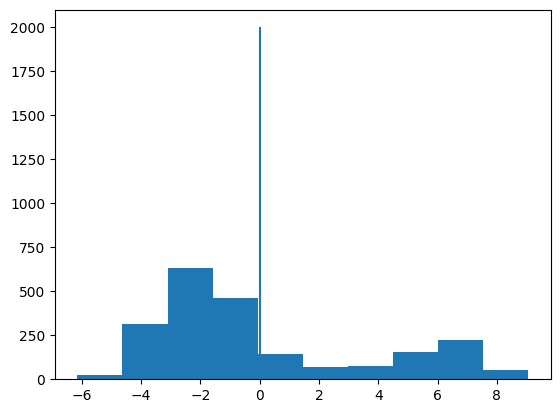

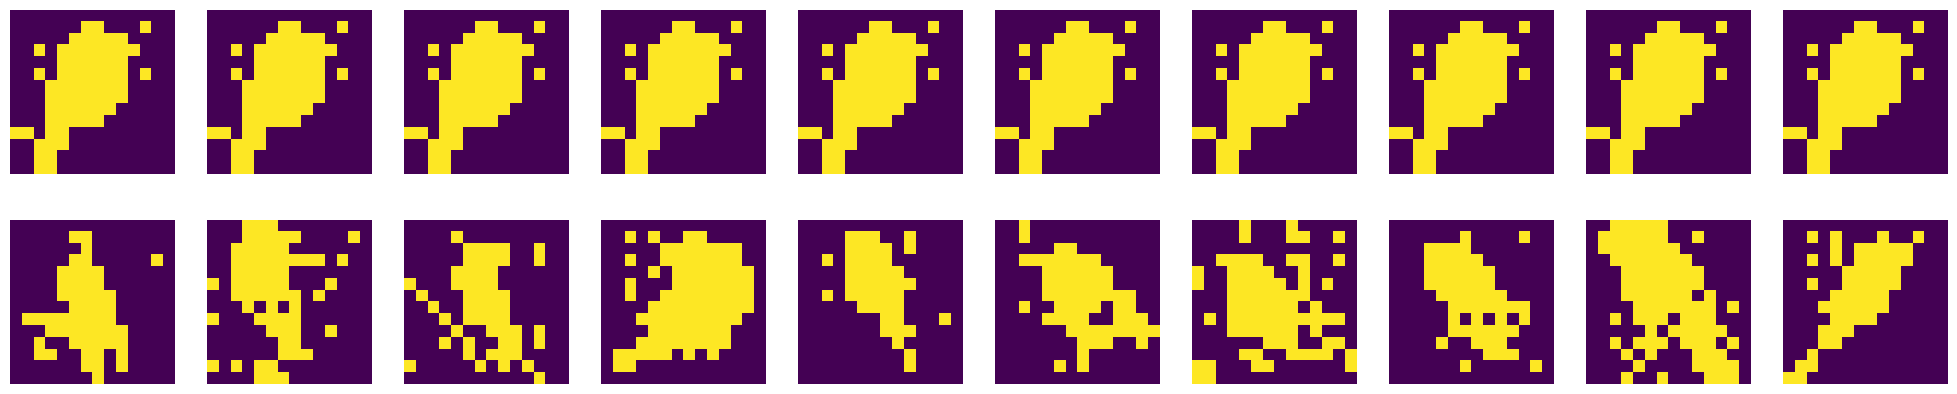

Query indices to show:  [140  33 115 107  52 106  50 130  76  35]
Prototype indices to show:  [ 674   47 1676  747  217  873  816  720  666  803]
Indices query prototype pairs to show:  [[[np.int64(33), np.int64(47)]], [[np.int64(52), np.int64(21)]], [[]], [[np.int64(140), np.int64(86)], [np.int64(107), np.int64(159)], [np.int64(130), np.int64(132)], [np.int64(76), np.int64(78)]], [[np.int64(106), np.int64(89)], [np.int64(50), np.int64(32)], [np.int64(35), np.int64(19)]], [[]], [[]], [[]], [[np.int64(115), np.int64(108)]], [[]]]
Paired indices to show:  [[[np.int64(33), np.int64(47)]], [[np.int64(52), np.int64(21)]], [[]], [[np.int64(140), np.int64(86)], [np.int64(107), np.int64(159)], [np.int64(130), np.int64(132)], [np.int64(76), np.int64(78)]], [[np.int64(106), np.int64(89)], [np.int64(50), np.int64(32)], [np.int64(35), np.int64(19)]], [[]], [[]], [[]], [[np.int64(115), np.int64(108)]], [[]]]
indices plot 1 :  [[(35, 77)], [(49, 147)], [], [(147, 7), (105, 133), (133, 63), (77, 91)]

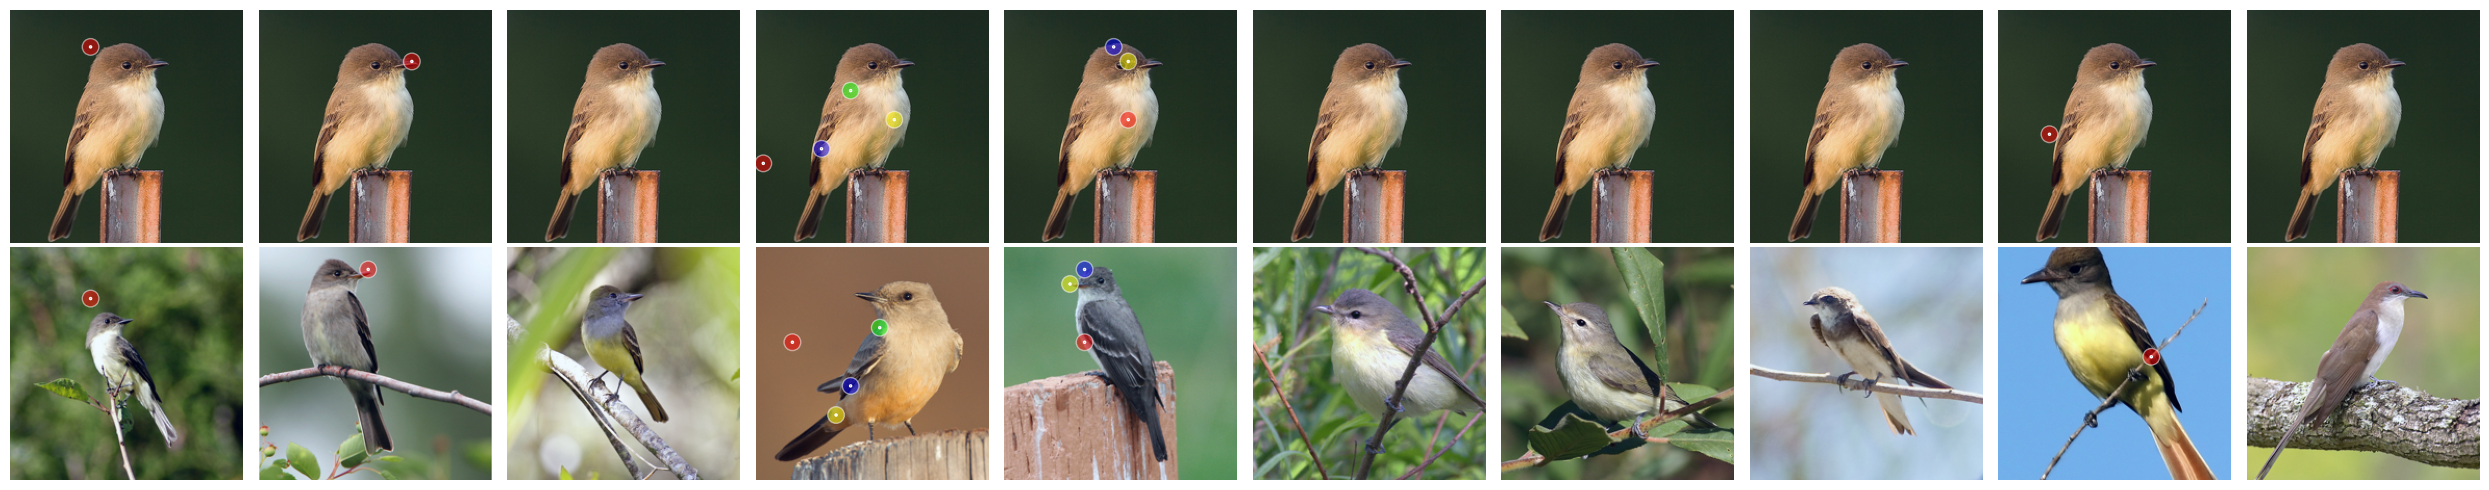

In [11]:
#@title Testing block
# This block makes prediction for a query (defined by test_sample) and plots
# the forgeground / background thresholding along with the preidction
# and the explanation.

# input an unknown sample to make prediction of classifcation and plot the correspondences
test_sample = 9
with torch.no_grad():
    print("Total samples in inputs:", len(inputs))
    predictions = kcc.predict_and_plot(inputs[test_sample].unsqueeze(0))
    

# print(predictions.argsort()[-5:])
# print(predictions[predictions.argsort()[-5:]])

# print(predictions.argmax())
# print(labels[test_sample])
print("Prediction argsort: ", predictions.argsort()[-5:])
print("Prediction argsort values: ", predictions[predictions.argsort()[-5:]])
print("Prediction argmax: ", predictions.argmax())
print("label of the sample:", labels[test_sample])



Below is the test code for the CLIP text model

c:\Users\chens\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


The part label that best matches the image is: 2 beak


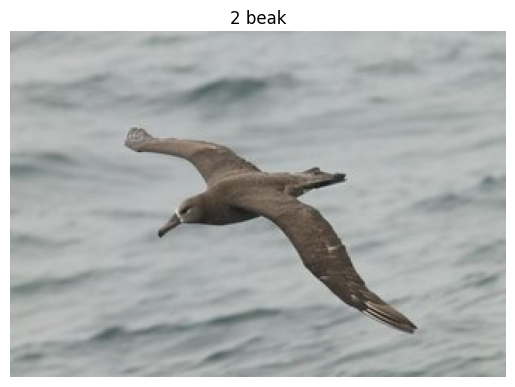

In [12]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

# Load the pre-trained CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Open the image file
image_path = '../data/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg'
image = Image.open(image_path)

# Load the parts file
parts_file = '../data/CUB_200_2011/parts/parts.txt'
with open(parts_file, 'r') as f:
    parts = [line.strip() for line in f.readlines()]

# Process the inputs : tokenize the text and encode the image
inputs = processor(text=parts, images=image, return_tensors="pt", padding=True, truncation=True)

# Compute embeddings
with torch.no_grad():
    outputs = model(**inputs)
    image_embeds = outputs.image_embeds
    text_embeds = outputs.text_embeds

# Normalize the embeddings
image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)

# Compute cosine similarity
cosine_similarities = torch.matmul(image_embeds, text_embeds.T)

# Find the index of the highest similarity score
best_match_idx = cosine_similarities.argmax().item()

# Retrieve the corresponding part label
best_match_label = parts[best_match_idx]

print(f"The part label that best matches the image is: {best_match_label}")

# use plt to show the image and the part label
plt.imshow(image)
plt.title(best_match_label)
plt.axis('off')
plt.show()



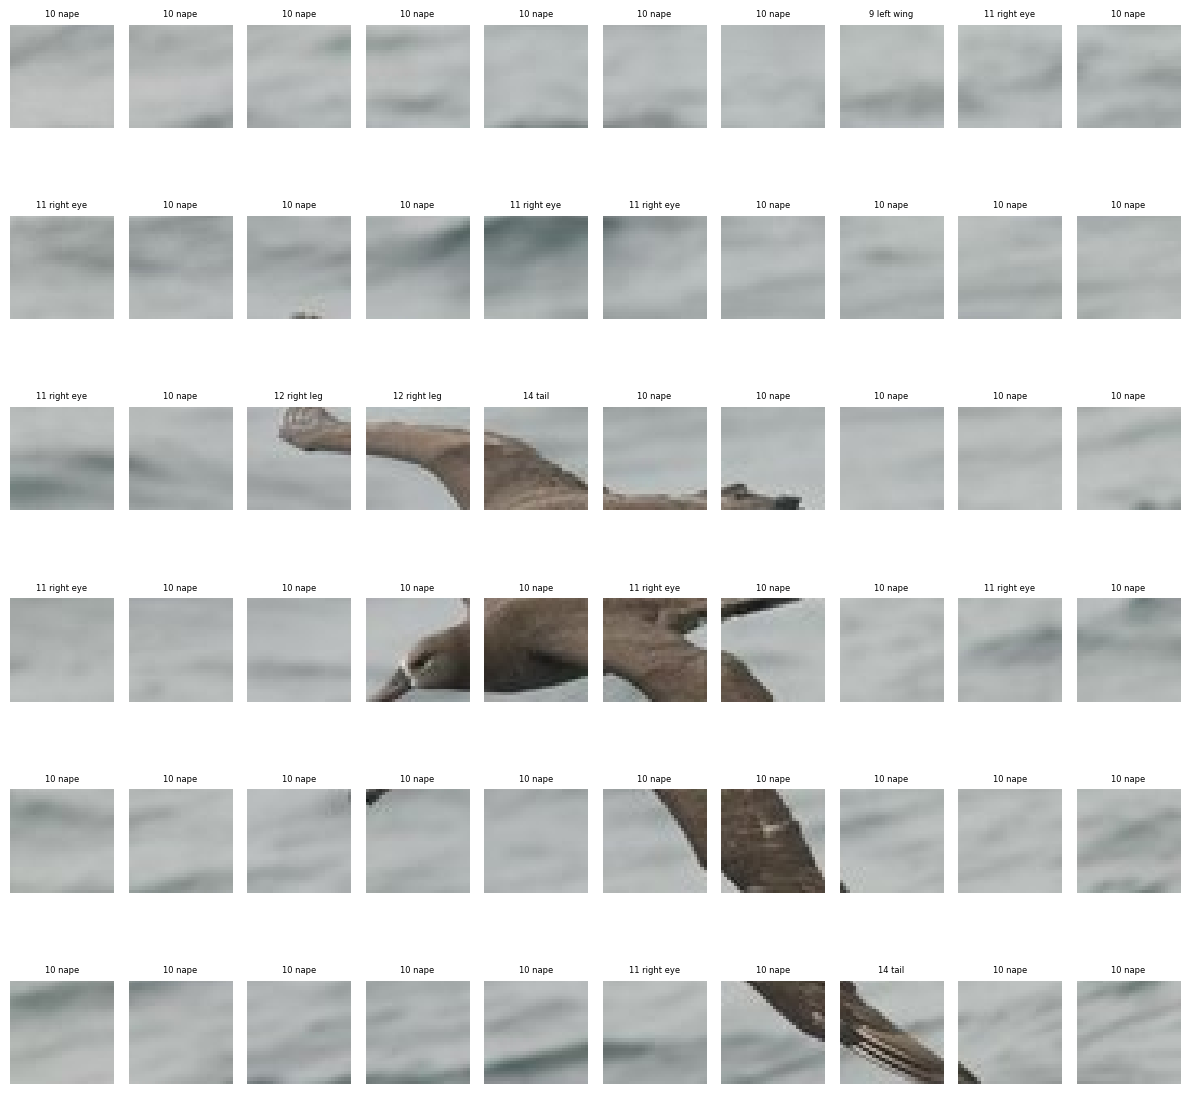

In [ ]:
import torch
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt

# Load the pre-trained CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Open the image file
image_path = '../data/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg'
image = Image.open(image_path).convert("RGB")

# Load the parts file
parts_file = '../data/CUB_200_2011/parts/parts.txt'
with open(parts_file, 'r') as f:
    parts = [line.strip() for line in f.readlines()]

# Divide image into patches
PATCH_SIZE = 32  # Set the patch size
image_array = np.array(image)
height, width, channels = image_array.shape

# divide the image into patches, // is floor division : 5//2 = 2
n_rows = height // PATCH_SIZE
n_cols = width // PATCH_SIZE

patches = []
for row in range(n_rows):
    for col in range(n_cols):
        patch = image_array[row * PATCH_SIZE:(row + 1) * PATCH_SIZE,
                            col * PATCH_SIZE:(col + 1) * PATCH_SIZE, :]
        patches.append(patch)

# Prepare parts embeddings
inputs = processor(text=parts, return_tensors="pt", padding=True, truncation=True)
with torch.no_grad():
    text_outputs = model.get_text_features(**inputs)
text_embeds = text_outputs / text_outputs.norm(dim=-1, keepdim=True)

# Process each patch
labels = []
for patch in patches:
    patch_image = Image.fromarray(patch)
    patch_inputs = processor(images=patch_image, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        patch_outputs = model.get_image_features(**patch_inputs)
    patch_embeds = patch_outputs / patch_outputs.norm(dim=-1, keepdim=True)
    
    # Compute similarity
    similarities = torch.matmul(patch_embeds, text_embeds.T)
    best_match_idx = similarities.argmax().item()
    labels.append(parts[best_match_idx])

# Visualize patches with labels
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))
patch_idx = 0
for i in range(n_rows):
    for j in range(n_cols):
        axs[i, j].imshow(patches[patch_idx])
        axs[i, j].set_title(labels[patch_idx], fontsize=6)
        axs[i, j].axis('off')
        patch_idx += 1
plt.tight_layout()
plt.show()


Everything below here is not really relevant. This code is used to extract prototypes and do some other types of testing. I will leave it here so you can have a look if you are interested.

In [14]:
# #@title create classwise dataset for prototype extraction

# from transformers import AutoProcessor

# processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")

# class Classwise_CUB(Dataset):
#     def __init__(self, base_path, target_class, train=True):

#         self.base_path = base_path
#         self.target_class = target_class
#         self.img_size = 224

#         self.labels = pd.read_csv(''.join([base_path, 'image_class_labels.txt']), header=None, sep=" ", names=["id", "label"])
#         self.train_test_split = pd.read_csv(''.join([base_path, 'train_test_split.txt']), header=None, sep=" ", names=["id", "is_train"])
#         self.filenames = pd.read_csv(''.join([base_path, 'images.txt']), header=None, sep=" ")

#         if train:
#           mask = self.train_test_split.is_train.values == 1
#         else:
#           mask = self.train_test_split.is_train.values == 0

#         self.filenames = self.filenames.iloc[mask]
#         self.labels = self.labels[mask]
#         self.classwise_filenames = []

#         for label_value, file_name in zip(self.labels['label'].values, self.filenames[1].values):
#             if (label_value-1) == target_class:
#                 self.classwise_filenames.append(file_name)
#             else:
#                 pass

#     def __len__(self):
#         return len(self.classwise_filenames)

#     def __getitem__(self, index):

#         y = self.target_class
#         file_name = self.classwise_filenames[index]

#         x = Image.open(''.join([self.base_path, 'images/', file_name])).convert('RGB')
#         x = processor(images=x, return_tensors="pt")

#         return x['pixel_values'].squeeze(), y, file_name

In [15]:
# #@title embedding function

# import random

# @torch.no_grad()
# def embed(encoder, dataloader):

#     representations = None

#     for batch_i, _, _ in dataloader:

#           if representations is None:
#               representations = encoder(batch_i.to('cuda')).pooler_output
#           else:
#               representations = torch.cat((representations, encoder(batch_i.to('cuda')).pooler_output))

#     return representations

In [16]:
# # !pip install scikit-learn-extra
# ! pip install pyclustering

In [17]:
# #@title create classwise datalaoder

# # from sklearn_extra.cluster import KMedoids
# from pyclustering.cluster.kmedoids import kmedoids as kmedoids
# import torch
# import numpy as np
# from torch.utils.data import DataLoader

# NUM_CLASSES = 200
# NUM_PROTOTYPES_PER_CLASS = 5
# REPRESENTATION_DIM = 768

# prototype_file_names = []
# prototype_labels = []
# prototype_representations = []

# # base_path = 'drive/MyDrive/CoSegXAI/datasets/cub200/CUB_200_2011/CUB_200_2011/'
# base_path = '../data/CUB_200_2011/' 
# with torch.no_grad():
#   for target_class in range(NUM_CLASSES):

#       print(target_class)

#       classwise_train_dataset = Classwise_CUB(base_path, target_class)
#       classwise_train_loader = DataLoader(classwise_train_dataset, batch_size=15, shuffle=False, num_workers=0, drop_last=False)

#       h = embed(model, classwise_train_loader)
#       h_numpy = h.numpy(force=True)  # Convert tensor to numpy array
      
#       # Choose random initial medoids for k-medoids
#       initial_medoids = np.random.choice(len(h_numpy), NUM_PROTOTYPES_PER_CLASS, replace=False)

#       # kmedoids = KMedoids(n_clusters=5).fit(h.numpy(force=True))
      
#        # Initialize and process k-medoids clustering
#       kmedoids_instance = kmedoids(h_numpy, initial_medoids)
#       kmedoids_instance.process()
      
#       # Get the indices of the medoids
#       medoid_indices = kmedoids_instance.get_medoids()

#       # for counter, idx in enumerate(kmedoids.medoid_indices_):
#       for idx in medoid_indices:
#           x, y, file_name = classwise_train_dataset.__getitem__(idx)
#           representations = model(x.unsqueeze(0).to('cuda'))

#           prototype_file_names.append(file_name)
#           prototype_labels.append(y)
#           prototype_representations.append(representations.pooler_output.to('cpu'))


In [18]:
# prototype_df = pd.DataFrame(prototype_file_names)
# # prototype_df.to_csv('drive/MyDrive/CoSegXAI/clip-vitp16_prototypes_5.csv', index=False)
# prototype_df.to_csv('../data/clip-vitp16_prototypes_5.csv', index=False)

In [19]:
# # df = pd.read_csv('drive/MyDrive/CoSegXAI/clip-vitp16_prototypes_5.csv')
# df = pd.read_csv('../data/clip-vitp16_prototypes_5.csv')

In [20]:
# import csv

# # with open('drive/MyDrive/CoSegXAI/clip-vitp16_5_prototypes_labels.csv', 'wb') as myfile:
# with open('../data/clip-vitp16_5_prototypes_labels.csv', 'w') as myfile:
#     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#     wr.writerow(prototype_labels)

In [21]:
# # pd.DataFrame(prototype_labels).to_csv('drive/MyDrive/CoSegXAI/clip-vitp16_5_prototypes_labels.csv')
# pd.DataFrame(prototype_labels).to_csv('../data/clip-vitp16_5_prototypes_labels.csv')

In [22]:
# # pd.DataFrame(prototype_file_names).to_csv('drive/MyDrive/CoSegXAI/clip-vitp16_5_prototypes_file_names.csv')
# pd.DataFrame(prototype_file_names).to_csv('../data/clip-vitp16_5_prototypes_file_names.csv')

In [23]:
# import csv

# # with open('drive/MyDrive/CoSegXAI/dinov2_vitb14_5_prototypes_file_names.csv', 'wb') as myfile:
# with open('../data/dinov2_vitb14_5_prototypes_file_names.csv', 'w') as myfile:
#     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#     wr.writerow(prototype_file_names)

In [24]:
# a = torch.stack(prototype_representations).squeeze()
# print(a.shape)

In [25]:
# # torch.save(torch.stack(prototype_representations).squeeze(), 'drive/MyDrive/CoSegXAI/clip-vitp16_5_prototypes_representation.pth')
# torch.save(torch.stack(prototype_representations).squeeze(), '../data/clip-vitp16_5_prototypes_representation.pth')

In [26]:
# from sklearn.metrics.pairwise import cosine_similarity

# out = cosine_similarity(np.random.rand(1, 200), np.random.rand(150, 200))
# ind = np.argpartition(out.flatten(), -4)[-4:]
# print(ind)



In [27]:
# prototype_file_names = []
# prototype_labels = []

# for class_i, file_names in df.iterrows():
#     for file_name in file_names.to_list():
#         prototype_file_names.append(file_name)
#         prototype_labels.append(class_i)



In [28]:
# top_k_indices = list(np.random.randint(0, len(prototype_file_names), 5).flatten())
# top_k_prototypes = [prototype_file_names[i] for i in top_k_indices]
# top_k_labels = [prototype_labels[i] for i in top_k_indices]


In [29]:
# #@title create classwise dataset for prototype extraction

# class Prototype_Dataset(Dataset):
#     def __init__(self, base_path, file_names, labels):

#         self.base_path = base_path
#         self.img_size = 392

#         self.labels = labels
#         self.file_names = file_names

#         self.transforms = Compose([
#                 ToTensor(),
#                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#                 ])

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, index):

#         y = self.labels[index]
#         file_name = self.file_names[index]

#         x = Image.open(''.join([self.base_path, 'images/', file_name])).resize((self.img_size, self.img_size)).convert('RGB')
#         x = self.transforms(x)

#         return x, y

# prototype_dataset = Prototype_Dataset(base_path, prototype_file_names, top_k_labels)
# prototype_loader = DataLoader(prototype_dataset, batch_size=len(top_k_indices), shuffle=False, num_workers=0)

In [30]:
# train_dataset = CUB(base_path)
# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)

# correct_labels = []
# predicted_labels = []

# for counter, (x, y) in enumerate(train_loader):

#   print(counter)
#   representations = model(x.to('cuda'))
  
  
#   similarity = cosine_similarity(representations, prototype_representations)
#   top_k_similar_prototypes_indices = torch.topk(similarity, 100)[1]
#   correct_labels.append(y.item())
#   predicted_labels.append([prototype_labels[i.item()] for i in top_k_similar_prototypes_indices])

#   if counter == 499: break

In [31]:
# correct_label_among_top_k_nns = []
# k = 10

# for correct_labels_i, predicted_labels_i in zip(correct_labels, predicted_labels):

#     correct_label_among_top_k_nns.append(correct_labels_i in predicted_labels_i[:k])

# print(correct_label_among_top_k_nns)
# print(sum(correct_label_among_top_k_nns) / 499)

In [32]:

# test_dataset = CUB(base_path, train=False)
# test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False, num_workers=0)

# from sklearn.neighbors import KNeighborsClassifier
# neigh = KNeighborsClassifier(n_neighbors=5)
# neigh.fit(prototype_representations.numpy(force=True), prototype_labels)

# with torch.no_grad():
#   for counter, (x, y) in enumerate(test_loader):

#       representations = model(x.to('cuda'))
#       print(neigh.score(representations.numpy(force=True), y.numpy(force=True)))

#       if counter == 10: break

In [33]:

# test_dataset = CUB(base_path, train=False)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

# acc_list = []

# with torch.no_grad():
#   for counter, (x, y) in enumerate(test_loader):
#       predictions = kcc.get_prediction(x)

#       acc_list.append(predictions.argmax() == y.item())



In [34]:
# import torch
# from torch.nn.functional import cosine_similarity

# a = torch.zeros((5, 768))
# b = torch.zeros((25, 768))

# sims = cosine_similarity(a[None, :, :], b[:, None, :], dim=-1)
# print(sims.shape)

# for ai in a:
#   print(cosine_similarity(ai, b, dim=-1))
#   raise
